# TIME SERIES OF KATABATIC WIND REGIONS
This notebook serves to visualize the wind speeds over the katabatic regions in a time series that spans from 1900-2100. This code was reproduced by Grace Woolslayer from Tyler Wassel's time series. Contact grace.woolslayer@temple.edu for questions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter
import cftime
import warnings

In [2]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/antarctica_mask_iceshelves/CM4_mask_withiceshelves.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/antarctica_mask_iceshelves/ESM4_mask_withiceshelves.nc')
mask_ERA5= xr.open_dataset('/home/pachamama/shared/antarctica_mask/antarctica_mask_iceshelves/ERA5_mask_withiceshelves.nc')
mask_CM4X= xr.open_dataset('/home/pachamama/shared/antarctica_mask/antarctica_mask_iceshelves/CM4X_mask_withiceshelves.nc'  )

In [3]:
#spatial weight function
def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """
    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

# Dense Shelf Water Regions

![](https://www.researchgate.net/publication/371674469/figure/fig2/AS:11431281250565214@1717898626675/Formation-regions-of-Dense-Shelf-Water-DSW-and-pathways-of-Antarctic-Bottom-Water.png)

[https://www.researchgate.net/figure/Formation-regions-of-Dense-Shelf-Water-DSW-and-pathways-of-Antarctic-Bottom-Water_fig2_371674469](https://www.researchgate.net/figure/Formation-regions-of-Dense-Shelf-Water-DSW-and-pathways-of-Antarctic-Bottom-Water_fig2_371674469)

---

 # <span style="color:red">CM4x historical</span>

In [4]:
#importing eastward wind output from cm4x historical simulation from backup
CM4X_uas=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/historical/atmos/monthly/u_ref/*.nc')

In [5]:
#importing northward wind output from cm4x historical simulation from backup
CM4X_vas=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/historical/atmos/monthly/v_ref/*.nc')

In [6]:
CM4X_vas_use=CM4X_vas.v_ref.sel(time=slice('1900-01-16','2014-12-16'))
CM4X_uas_use=CM4X_uas.u_ref.sel(time=slice('1900-01-16','2014-12-16'))

In [7]:
cm4x_his_mergewinds = xr.merge([CM4X_vas_use,CM4X_uas_use]) # merge winds to make it easy
cm4x_his_mergewinds_xmerge = cm4x_his_mergewinds.lon #extracting the lon component fomr the mergewinds array
cm4x_his_mergewinds_ymerge = cm4x_his_mergewinds.lat
cm4x_his_mergewinds_umerge = cm4x_his_mergewinds.u_ref 
cm4x_his_mergewinds_vmerge = cm4x_his_mergewinds.v_ref
cm4x_his_speedmerge = np.sqrt(np.square(cm4x_his_mergewinds_umerge) + np.square(cm4x_his_mergewinds_vmerge)) ## calculating speed using vector formula
## average
CM4X_historical_speed = cm4x_his_speedmerge.sel(time=slice('1900-01-16','2014-12-16'))

In [8]:
lat_CM4x_historical = cm4x_his_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4x_historical = cm4x_his_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4x_historical,lon_CM4x_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4x_historical = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4x_his_speedmerge.coords['lat'],\
                                                        cm4x_his_speedmerge.coords['lon']))

In [9]:
weights_CM4X_historical=areacell_CM4x_historical

# CM4x SSP585

In [10]:
CM4X_uas_ssp585=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/ssp585/atmos/monthly/u_ref/*.nc')


In [11]:
CM4X_vas_ssp585=xr.open_mfdataset('/backup/tuq41374/model_output/cm4x/p25/ssp585/atmos/monthly/v_ref/*.nc')
CM4X_vas_ssp585

<xarray.Dataset>
Dimensions:     (time: 1020, bnds: 2, lat: 360, lon: 576)
Coordinates:
  * bnds        (bnds) float64 1.0 2.0
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon         (lon) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * time        (time) object 2015-01-16 12:00:00 ... 2099-12-16 12:00:00
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(60, 360, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(60, 576, 2), meta=np.ndarray>
    time_bnds   (time, bnds) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    v_ref       (time, lat, lon) float32 dask.array<chunksize=(60, 360, 576), meta=np.ndarray>
Attributes:
    filename:              atmos.201501-201912.v_ref.nc
    title:                 CM4_ssp585_c192_OM4p25
    associated_files:      area: 20190101.grid_spec.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Thu Feb 16 13:17:56 2023
    hostname:              pp033
    history:               fregrid --standard_dimension --input_mosaic C192_m...

In [12]:
CM4X_ssp_uas_use=CM4X_uas_ssp585.sel(time=slice('2015-01-16', '2100-12-16'))
CM4X_ssp_vas_use=CM4X_vas_ssp585.sel(time=slice('2015-01-16', '2100-12-16'))

In [13]:
cm4x_ssp_mergewinds = xr.merge([CM4X_ssp_uas_use,CM4X_ssp_vas_use]) # merge winds to make it easy
cm4x_ssp_mergewinds_xmerge = cm4x_ssp_mergewinds.lon #extracting the lon component fomr the mergewinds array
cm4x_ssp_mergewinds_ymerge = cm4x_ssp_mergewinds.lat
cm4x_ssp_mergewinds_umerge = cm4x_ssp_mergewinds.u_ref 
cm4x_ssp_mergewinds_vmerge = cm4x_ssp_mergewinds.v_ref
cm4x_ssp_speedmerge = np.sqrt(np.square(cm4x_ssp_mergewinds_umerge) + np.square(cm4x_ssp_mergewinds_vmerge)) ## calculating speed using vector formula
## average
CM4X_SSP_speed = cm4x_ssp_speedmerge.sel(time=slice('2015-01-16', '2100-12-16'))

In [14]:
lat_CM4x_ssp = cm4x_ssp_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4x_ssp = cm4x_ssp_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4x_ssp,lon_CM4x_ssp)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4x_ssp = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4x_ssp_speedmerge.coords['lat'],\
                                                        cm4x_ssp_speedmerge.coords['lon']))

In [15]:
weights_CM4X_SSP=areacell_CM4x_ssp

# ESM4 historical 

In [16]:
esm4 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

ESM4_uas = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True)

#defines the NorthWard Near-Surface Wind
gfdl_esm4_vas_data = esm4.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'historical' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

zstore_esm4_vas = gfdl_esm4_vas_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

ESM4_vas = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True)

In [17]:
ESM4_historical_uas=ESM4_uas.uas.sel(time=slice('1900-01-16','2014-12-16'))

In [18]:
ESM4_historical_vas = ESM4_vas.vas.sel(time=slice('1900-01-16','2014-12-16'))

In [19]:
mergedwindse4 = xr.merge([ESM4_historical_uas,ESM4_historical_vas])
esm4_xmerge=mergedwindse4.lon
esm4_ymerge=mergedwindse4.lat
esm4_umerge=mergedwindse4.uas
esm4_vmerge=mergedwindse4.vas
esm4_speed_merge=np.sqrt(np.square(esm4_umerge) + np.square(esm4_vmerge))
esm4_speed_merge
#wind speed around antarctica 

ESM4_historical_speed = esm4_speed_merge.sel(time=slice('1900-01-16','2014-12-16'))


In [20]:
ESM4_historical_speed

<xarray.DataArray (time: 1380, lat: 180, lon: 288)>
dask.array<sqrt, shape=(1380, 180, 288), dtype=float32, chunksize=(581, 180, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1900-01-16 12:00:00 ... 2014-12-16 12:00:00

In [21]:
lat_esm4_historical = esm4_speed_merge.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_historical = esm4_speed_merge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_his_areacell = standard_grid_cell_area(lat_esm4_historical,lon_esm4_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_historical = xr.DataArray(esm4_his_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(esm4_speed_merge.coords['lat'],\
                                                        esm4_speed_merge.coords['lon']))

In [22]:
weights_ESM4_historical=areacell_esm4_historical

# ESM4 ssp585

In [23]:
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
#defines the Eastward Near-Surface Wind
gfdl_esm4_uas_ssp_data = google_cloud_cmip6.query(
    "table_id == 'Amon' & \
    variable_id == 'uas' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

gcs = gcsfs.GCSFileSystem(token='anon')
zstore_esm4_uas = gfdl_esm4_uas_ssp_data.zstore.values[-1]
mapper_esm4_uas = gcs.get_mapper(zstore_esm4_uas)

ESM4_uas_ssp = xr.open_zarr(mapper_esm4_uas, 
                                consolidated=True,use_cftime=True).uas


In [24]:
#defines the NorthWard Near-Surface Wind
gfdl_esm4_vas_ssp_data = google_cloud_cmip6.query(
    "table_id == 'Amon' & \
    variable_id == 'vas' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4'")

zstore_esm4_vas = gfdl_esm4_vas_ssp_data.zstore.values[-1]
mapper_esm4_vas = gcs.get_mapper(zstore_esm4_vas)

ESM4_vas_ssp = xr.open_zarr(mapper_esm4_vas, 
                                consolidated=True,use_cftime=True).vas


In [25]:
ESM4_SSP_uas=ESM4_uas_ssp.sel(time=slice('2015-01-16','2100-12-16'))

In [26]:
ESM4_SSP_vas = ESM4_vas_ssp.sel(time=slice('2015-01-16','2100-12-16'))#northward wind variable

In [27]:
ssp_mergedwindse4 = xr.merge([ESM4_SSP_uas,ESM4_SSP_vas])
ssp_esm4_xmerge=ssp_mergedwindse4.lon
ssp_esm4_ymerge=ssp_mergedwindse4.lat
ssp_esm4_umerge=ssp_mergedwindse4.uas
ssp_esm4_vmerge=ssp_mergedwindse4.vas
ssp_esm4_speed_merge=np.sqrt(np.square(ssp_esm4_umerge) + np.square(ssp_esm4_vmerge))
ssp_esm4_speed_merge
#wind speed around antarctica 

ESM4_SSP_speed = ssp_esm4_speed_merge.sel(time=slice('2015-01-16','2100-12-16'))


In [28]:
lat_esm4_ssp = ssp_esm4_speed_merge.coords['lat'].values #1-D numpy array of model's latitude values
lon_esm4_ssp = ssp_esm4_speed_merge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
esm4_ssp_areacell = standard_grid_cell_area(lat_esm4_ssp,lon_esm4_ssp)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_esm4_ssp = xr.DataArray(esm4_his_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(ssp_esm4_speed_merge.coords['lat'],\
                                                        ssp_esm4_speed_merge.coords['lon']))

In [29]:
weights_ESM4_SSP=areacell_esm4_ssp

# CM4 historical

In [30]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
CM4_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
CM4_historical_uas_data = CM4_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'uas'& table_id == 'Amon'")

# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = CM4_historical_uas_data.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_uas_historical_use = xr.open_zarr(mapper, consolidated=True)
CM4_historical_uas = ds_uas_historical_use.uas #extracting uas variable


In [31]:



##importing Northward Near-Surface Wind data from google cloud.
df_vas_historical = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
	
# step two … # replace with the id you need and other info to ween down datasets 
df_v_historical = df_vas_historical.query("source_id=='GFDL-CM4' & experiment_id == 'historical' & variable_id == 'vas'& table_id == 'Amon'")

# step three 
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v_historical.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
ds_vas_historical = xr.open_zarr(mapper, consolidated=True)
CM4_historical_vas=ds_vas_historical.vas

In [32]:
## merge winds by merging eastward and northward.
#extracting just uas and vas data
CM4_historical_uas = ds_uas_historical_use.uas.sel(time=slice('1900-01-16','2014-12-16'))
CM4_historical_vas=ds_vas_historical.vas.sel(time=slice('1900-01-16','2014-12-16'))

his_mergewinds = xr.merge([CM4_historical_uas,CM4_historical_vas]) # merge winds to make it easy
cm4_his_xmerge = his_mergewinds.lon #extracting the lon component fomr the mergewinds array
cm4_his_ymerge = his_mergewinds.lat
cm4_his_umerge = his_mergewinds.uas 
cm4_his_vmerge = his_mergewinds.vas
cm4_his_speedmerge = np.sqrt(np.square(cm4_his_umerge) + np.square(cm4_his_vmerge)) ## calculating speed using vector formula
## average



### slicing the speed for the south pole
CM4_historical_speed = cm4_his_speedmerge
## UAS seasonal dataset

## merging the UAS seasonal and Vas seasonal to get merge seasonal


In [33]:
lat_CM4_historical = cm4_his_speedmerge.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_historical = cm4_his_speedmerge.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_CM4_historical,lon_CM4_historical)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_historical = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(cm4_his_speedmerge.coords['lat'],\
                                                        cm4_his_speedmerge.coords['lon']))

In [34]:
weights_CM4_historical=areacell_CM4_historical

# 


CM4 ssp585

In [35]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_uas_cm4_ssp = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')	
# step two … # replace with the id you need and other info to ween down datasets 
df_u_cm4_ssp = df_uas_cm4_ssp.query("source_id=='GFDL-CM4' & experiment_id == 'ssp585' & variable_id == 'uas'& table_id == 'Amon'")
# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_u_cm4_ssp.zstore.values[-1]
mapper = gcs.get_mapper(zstore)

CM4_SSP_uas_data = xr.open_zarr(mapper, consolidated=True)


In [36]:
##importing Eastward Near-Surface Wind data from google cloud. Amon
df_vas_cm4_ssp = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

# step two … # replace with the id you need and other info to ween down datasets 
df_v_cm4_ssp =df_vas_cm4_ssp.query("source_id=='GFDL-CM4' & experiment_id == 'ssp585' & variable_id == 'vas'& table_id == 'Amon'")

# step three - loading in the data and storing it
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = df_v_cm4_ssp.zstore.values[-1]
mapper = gcs.get_mapper(zstore)
CM4_SSP_vas_data = xr.open_zarr(mapper, consolidated=True)


In [37]:
#defining variables that extract wind speed variables
CM4_SSP_uas=CM4_SSP_uas_data.uas.sel(time=slice('2015-01-16','2100-12-16'))
CM4_SSP_vas=CM4_SSP_vas_data.vas.sel(time=slice('2015-01-16','2100-12-16'))

In [38]:
cm4_ssp_mergewinds = xr.merge([CM4_SSP_uas,CM4_SSP_vas]) # merge winds to make it easy
cm4_ssp_xmerge = cm4_ssp_mergewinds.lon #extracting the lon component from the mergewinds array
cm4_ssp_ymerge = cm4_ssp_mergewinds.lat
cm4_ssp_umerge = cm4_ssp_mergewinds.uas 
cm4_ssp_vmerge = cm4_ssp_mergewinds.vas
CM4_SSP_speed = np.sqrt(np.square(cm4_ssp_umerge) + np.square(cm4_ssp_vmerge)) ## calculating speed using vector formula

In [39]:
## average time for quiver plots
cm4_ssp_timeaveragemerge = CM4_SSP_speed.sel(time=slice('2081-01-16','2100-12-16')).mean(dim='time')

### the data that is used for overall regional speed
cm4_ssp_speedslice = CM4_SSP_speed.mean(dim='time')

In [40]:
lat_CM4_ssp = CM4_SSP_speed.coords['lat'].values #1-D numpy array of model's latitude values
lon_CM4_ssp = CM4_SSP_speed.coords['lon'].values #1-D numpy array of model's longitude values
# make sure to replace the name of the data array if you chose a
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.
# Pass the arrays to the standard_grid_cell_area function
cm4_ssp_areacell = standard_grid_cell_area(lat_CM4_ssp,lon_CM4_ssp)

# The areacella_xarray function outputs a numpy array. Convert this back into
# and xarray DataArray for further use. If this is a field you will be using
# often. You may wish to save this newly created DataArray as a Dataset and save
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:
areacell_CM4_ssp = xr.DataArray(cm4_ssp_areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(CM4_SSP_speed.coords['lat'],\
                                                        CM4_SSP_speed.coords['lon']))

In [41]:
weights_CM4_SSP=areacell_CM4_ssp

# Creating Time Series

In [42]:
#DSW masks
mask_CM4_dsw= xr.open_dataset('/home/pachamama/shared/dsw_masks/CM4_mask_dsw.nc')
mask_ESM4_dsw= xr.open_dataset('/home/pachamama/shared/dsw_masks/ESM4_mask_dsw.nc')
mask_ERA5_dsw= xr.open_dataset('/home/pachamama/shared/dsw_masks/ERA5_mask_dsw.nc')
mask_CM4X_dsw= xr.open_dataset('/home/pachamama/shared/dsw_masks/CM4X_mask_dsw.nc')

In [43]:
#combing historical and ssp to make one line
CM4_combined_timeseries=xr.combine_by_coords([CM4_historical_speed, CM4_SSP_speed], join="override")
ESM4_combined_timeseries=xr.combine_by_coords([ESM4_historical_speed,ESM4_SSP_speed], join="override")
CM4X_combined_timeseries=xr.combine_by_coords([CM4X_historical_speed, CM4X_SSP_speed], join="override")

In [44]:
CM4_weddell_dsw_timeseries_slice=(CM4_combined_timeseries*mask_CM4_dsw.weddell_CM4).weighted(weights_CM4_historical).mean(dim=['lat', 'lon'])
CM4_weddell_dsw_timeseries=ml.util.annual_average(CM4_weddell_dsw_timeseries_slice, tcoord='time')

CM4_ross_dsw_timeseries_slice=(CM4_combined_timeseries*mask_CM4_dsw.ross_CM4).weighted(weights_CM4_historical).mean(dim=['lat', 'lon'])
CM4_ross_dsw_timeseries=ml.util.annual_average(CM4_ross_dsw_timeseries_slice, tcoord='time')

CM4_adelie_dsw_timeseries_slice=(CM4_combined_timeseries*mask_CM4_dsw.adelie_CM4).weighted(weights_CM4_historical).mean(dim=['lat', 'lon'])
CM4_adelie_dsw_timeseries=ml.util.annual_average(CM4_adelie_dsw_timeseries_slice, tcoord='time')

CM4_pbay_dsw_timeseries_slice=(CM4_combined_timeseries*mask_CM4_dsw.pbay_CM4).weighted(weights_CM4_historical).mean(dim=['lat', 'lon'])
CM4_pbay_dsw_timeseries=ml.util.annual_average(CM4_pbay_dsw_timeseries_slice, tcoord='time')

In [45]:
ESM4_weddell_dsw_timeseries_slice=(ESM4_combined_timeseries*mask_ESM4_dsw.weddell_ESM4).weighted(weights_ESM4_historical).mean(dim=['lat', 'lon'])
ESM4_weddell_dsw_timeseries=ml.util.annual_average(ESM4_weddell_dsw_timeseries_slice, tcoord='time')

ESM4_ross_dsw_timeseries_slice=(ESM4_combined_timeseries*mask_ESM4_dsw.ross_ESM4).weighted(weights_ESM4_historical).mean(dim=['lat', 'lon'])
ESM4_ross_dsw_timeseries=ml.util.annual_average(ESM4_ross_dsw_timeseries_slice, tcoord='time')

ESM4_adelie_dsw_timeseries_slice=(ESM4_combined_timeseries*mask_ESM4_dsw.adelie_ESM4).weighted(weights_ESM4_historical).mean(dim=['lat', 'lon'])
ESM4_adelie_dsw_timeseries=ml.util.annual_average(ESM4_adelie_dsw_timeseries_slice, tcoord='time')

ESM4_pbay_dsw_timeseries_slice=(ESM4_combined_timeseries*mask_ESM4_dsw.pbay_ESM4).weighted(weights_ESM4_historical).mean(dim=['lat', 'lon'])
ESM4_pbay_dsw_timeseries=ml.util.annual_average(ESM4_pbay_dsw_timeseries_slice, tcoord='time')

In [46]:
CM4X_weddell_dsw_timeseries_slice=(CM4X_combined_timeseries*mask_CM4X_dsw.weddell_CM4X).weighted(weights_CM4X_historical).mean(dim=['lat', 'lon'])
CM4X_weddell_dsw_timeseries=ml.util.annual_average(CM4X_weddell_dsw_timeseries_slice, tcoord='time')

CM4X_ross_dsw_timeseries_slice=(CM4X_combined_timeseries*mask_CM4X_dsw.ross_CM4X).weighted(weights_CM4X_historical).mean(dim=['lat', 'lon'])
CM4X_ross_dsw_timeseries=ml.util.annual_average(CM4X_ross_dsw_timeseries_slice, tcoord='time')

CM4X_adelie_dsw_timeseries_slice=(CM4X_combined_timeseries*mask_CM4X_dsw.adelie_CM4X).weighted(weights_CM4X_historical).mean(dim=['lat', 'lon'])
CM4X_adelie_dsw_timeseries=ml.util.annual_average(CM4X_adelie_dsw_timeseries_slice, tcoord='time')

CM4X_pbay_dsw_timeseries_slice=(CM4X_combined_timeseries*mask_CM4X_dsw.pbay_CM4X).weighted(weights_CM4X_historical).mean(dim=['lat', 'lon'])
CM4X_pbay_dsw_timeseries=ml.util.annual_average(CM4X_pbay_dsw_timeseries_slice, tcoord='time')

---

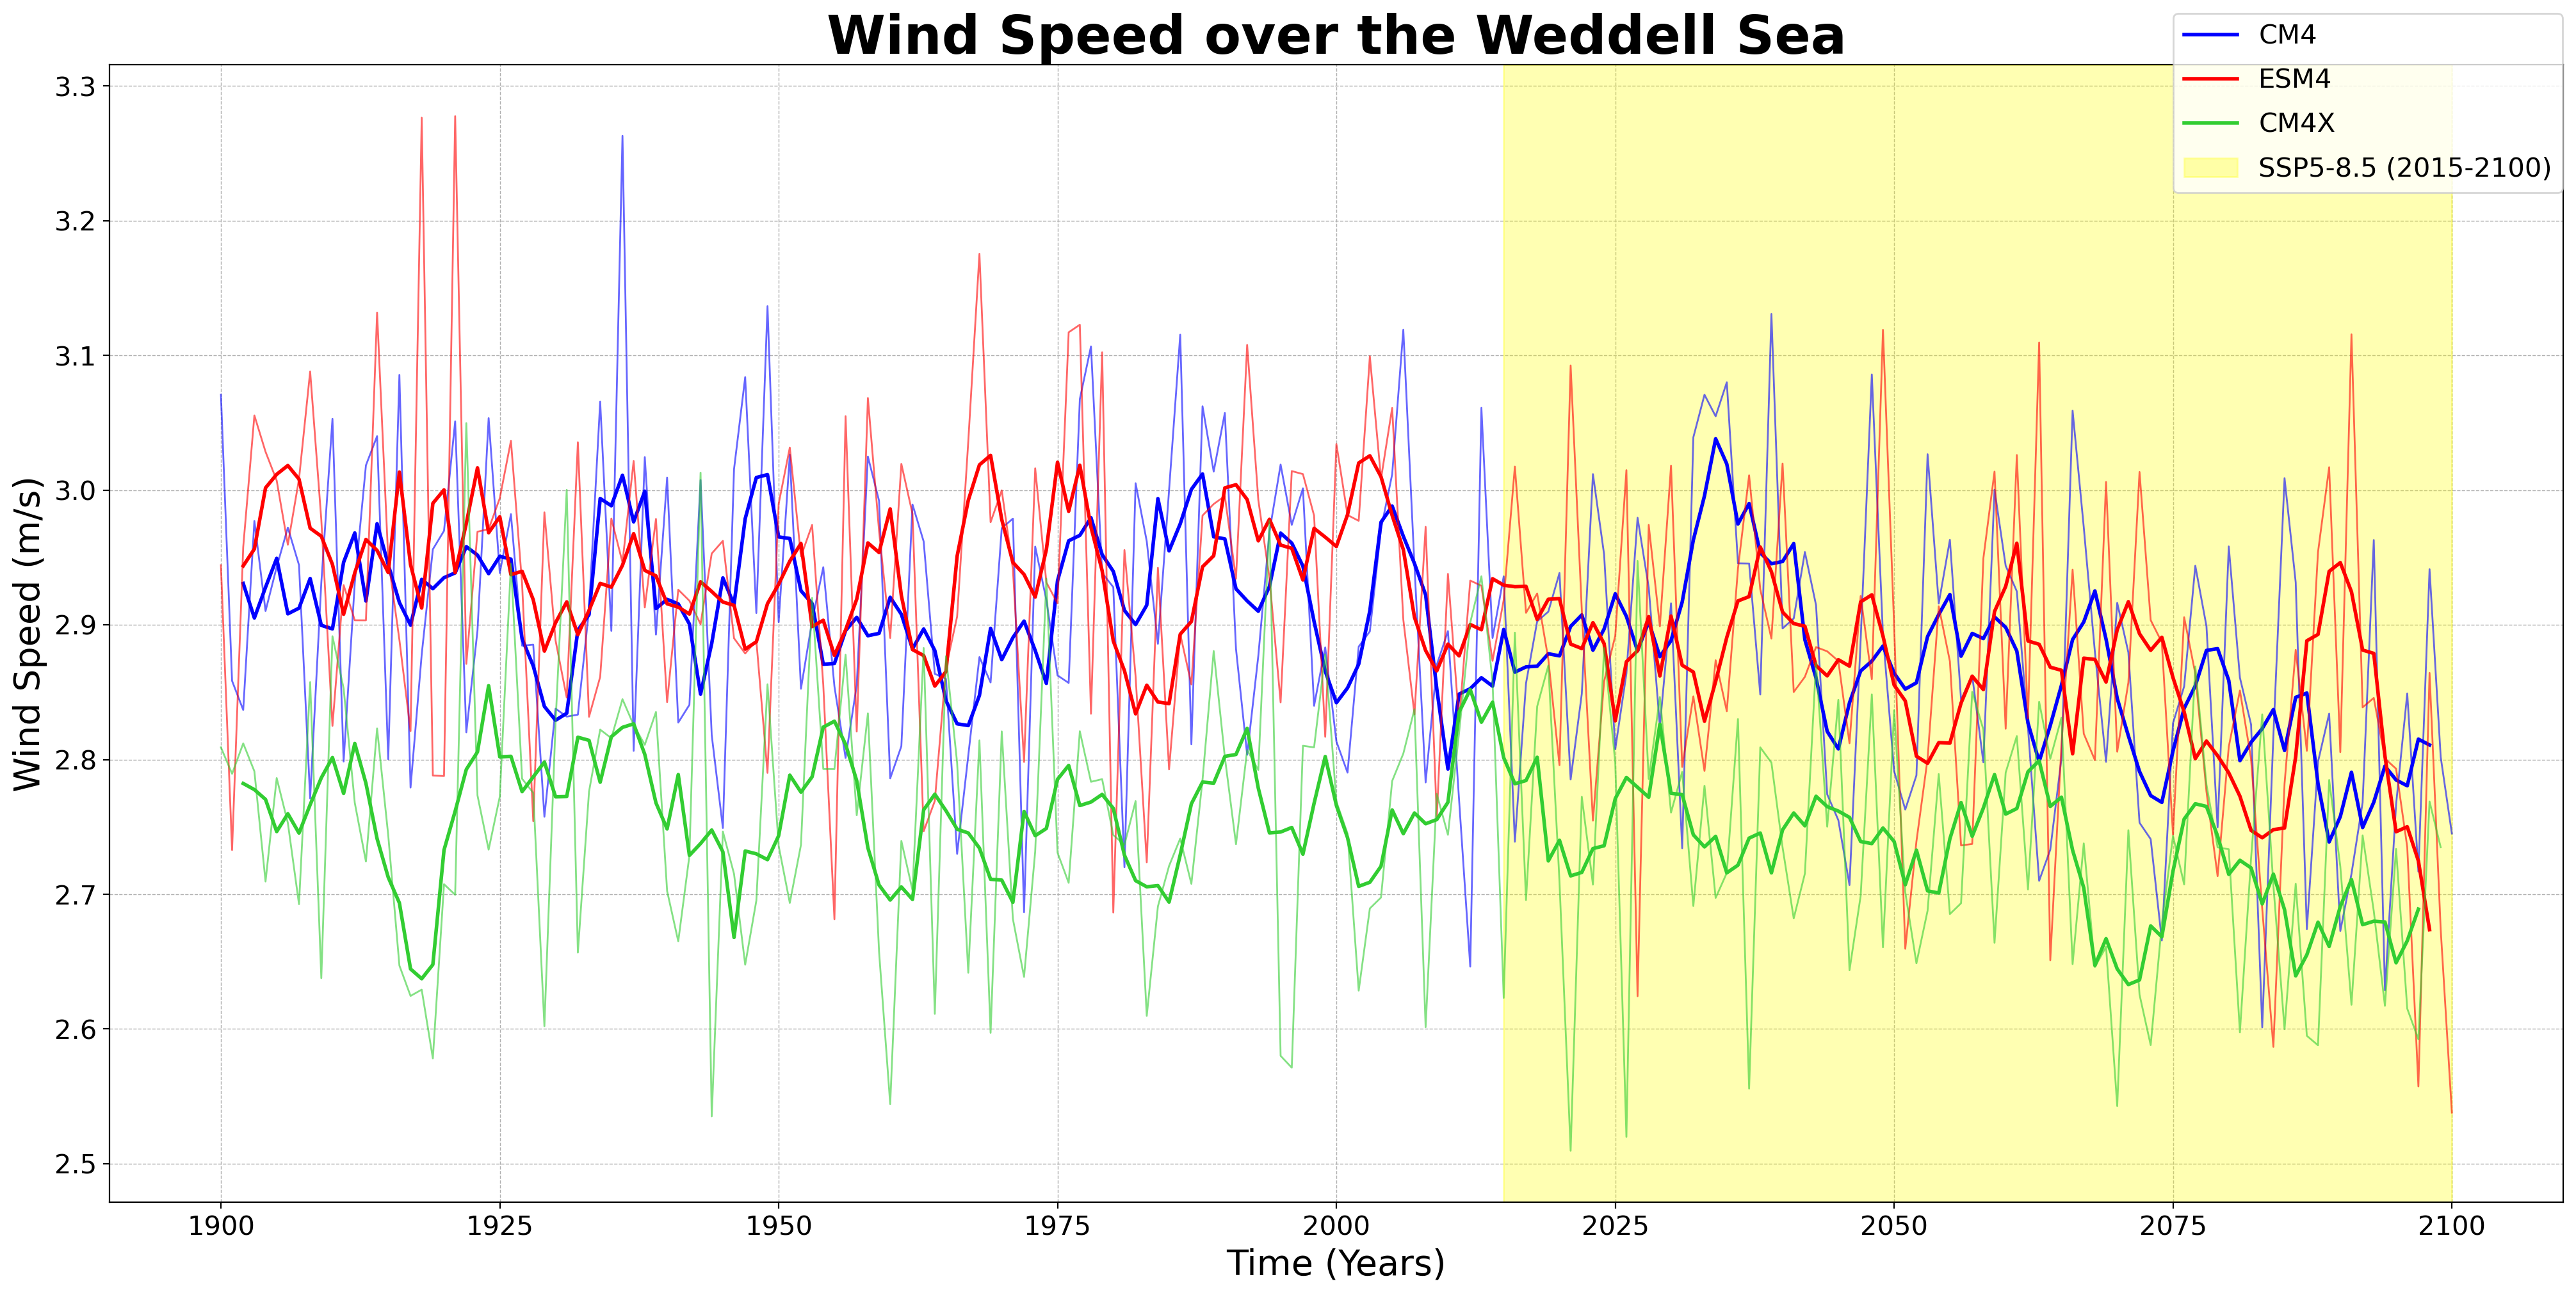

In [47]:

fig, ax= plt.subplots( layout='constrained', figsize= (20,10))

ax.plot(CM4_weddell_dsw_timeseries.time.dt.year,
           CM4_weddell_dsw_timeseries,
           color='blue', linewidth=1, alpha=0.6)

ax.plot(CM4_weddell_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4_weddell_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='blue', label='CM4', linewidth=2)


ax.plot(ESM4_weddell_dsw_timeseries.time.dt.year,
           ESM4_weddell_dsw_timeseries,
           color='red', linewidth=1, alpha=0.6)

ax.plot(ESM4_weddell_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           ESM4_weddell_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='red', label='ESM4', linewidth=2)


ax.plot(CM4X_weddell_dsw_timeseries.time.dt.year,
           CM4X_weddell_dsw_timeseries,
           color='limegreen', linewidth=1, alpha=0.6)

ax.plot(CM4X_weddell_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4X_weddell_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='limegreen', label='CM4X', linewidth=2)


#ax.plot(ERA5_weddell_dsw_timeseries.time.dt.year, ERA5_weddell_dsw_timeseries, color='black', linewidth=1, alpha=0.6)

#ax.plot(ERA5_weddell_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,ERA5_weddell_dsw_timeseries.rolling(time=5,center=True).mean(), color='black', label='ERA5', linewidth=2)



ax.set_title('Wind Speed over the Weddell Sea', fontsize=30, fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)



ax.set_ylabel('Wind Speed (m/s)', fontsize=20)
ax.set_xlabel('Time (Years)', fontsize=20)


ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)

ax.axvspan(2015, 2100, color='yellow', alpha=0.3, label='SSP5-8.5 (2015-2100)')

fig.legend(labelspacing=0.7, fontsize=15)






#plt.savefig('WeddellGradient_wind.png')

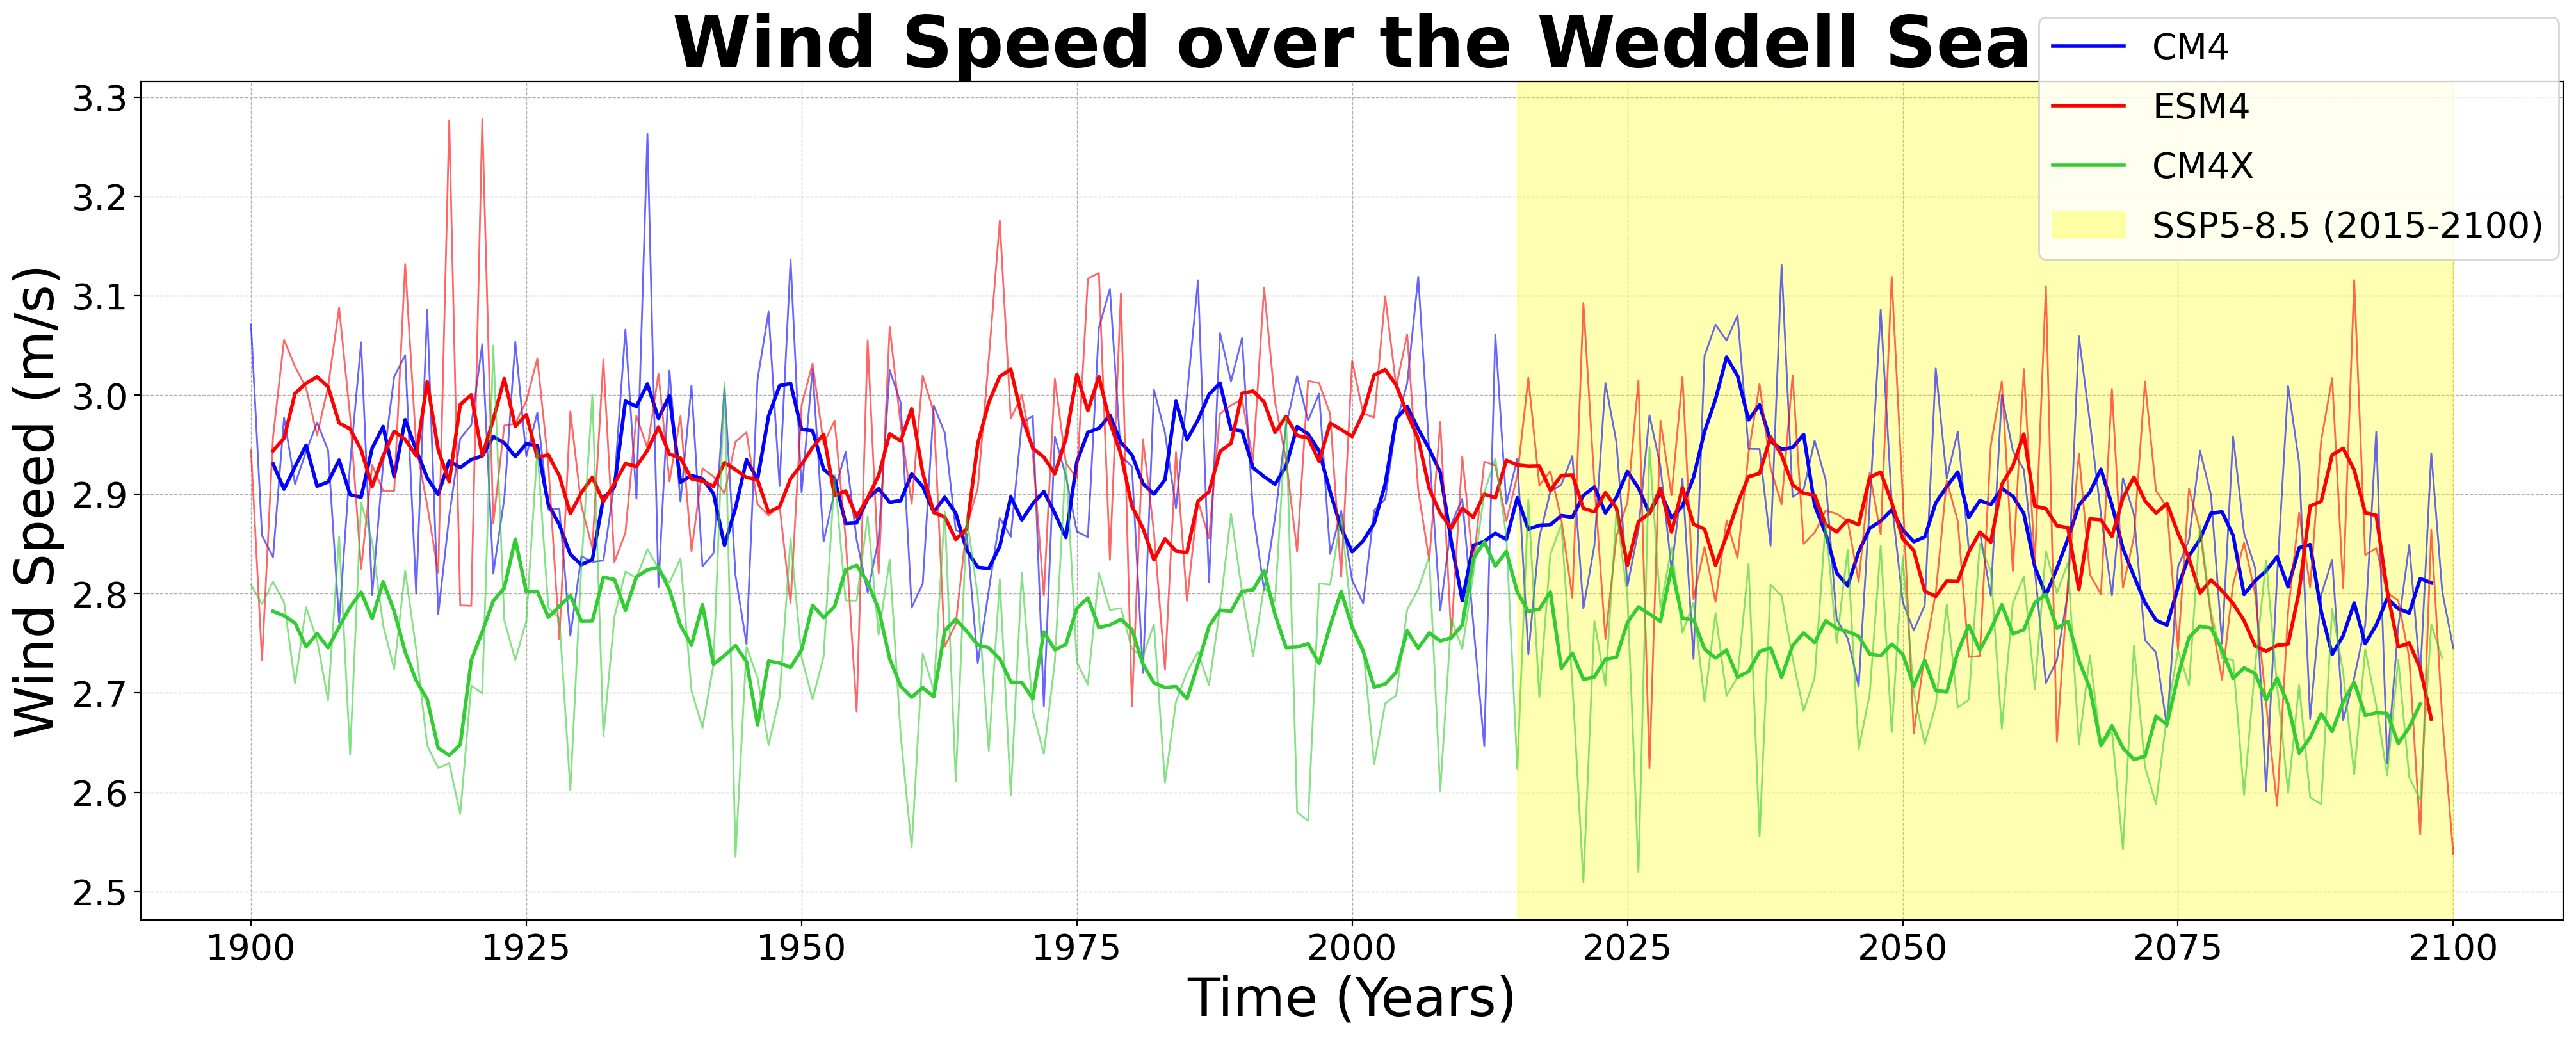

In [48]:

fig, ax= plt.subplots( layout='constrained', figsize= (20,8))

ax.plot(CM4_weddell_dsw_timeseries.time.dt.year,
           CM4_weddell_dsw_timeseries,
           color='blue', linewidth=1, alpha=0.6)

ax.plot(CM4_weddell_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4_weddell_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='blue', label='CM4', linewidth=2)


ax.plot(ESM4_weddell_dsw_timeseries.time.dt.year,
           ESM4_weddell_dsw_timeseries,
           color='red', linewidth=1, alpha=0.6)

ax.plot(ESM4_weddell_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           ESM4_weddell_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='red', label='ESM4', linewidth=2)


ax.plot(CM4X_weddell_dsw_timeseries.time.dt.year,
           CM4X_weddell_dsw_timeseries,
           color='limegreen', linewidth=1, alpha=0.6)

ax.plot(CM4X_weddell_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4X_weddell_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='limegreen', label='CM4X', linewidth=2)


#ax.plot(ERA5_weddell_dsw_timeseries.time.dt.year, ERA5_weddell_dsw_timeseries, color='black', linewidth=1, alpha=0.6)

#ax.plot(ERA5_weddell_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,ERA5_weddell_dsw_timeseries.rolling(time=5,center=True).mean(), color='black', label='ERA5', linewidth=2)



ax.set_title('Wind Speed over the Weddell Sea', fontsize=40, fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)



ax.set_ylabel('Wind Speed (m/s)', fontsize=30)
ax.set_xlabel('Time (Years)', fontsize=30)


ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)

ax.axvspan(2015, 2100, color='yellow', alpha=0.3, label='SSP5-8.5 (2015-2100)')

fig.legend(labelspacing=0.7, fontsize=20)






#plt.savefig('WeddellGradient_wind.png')

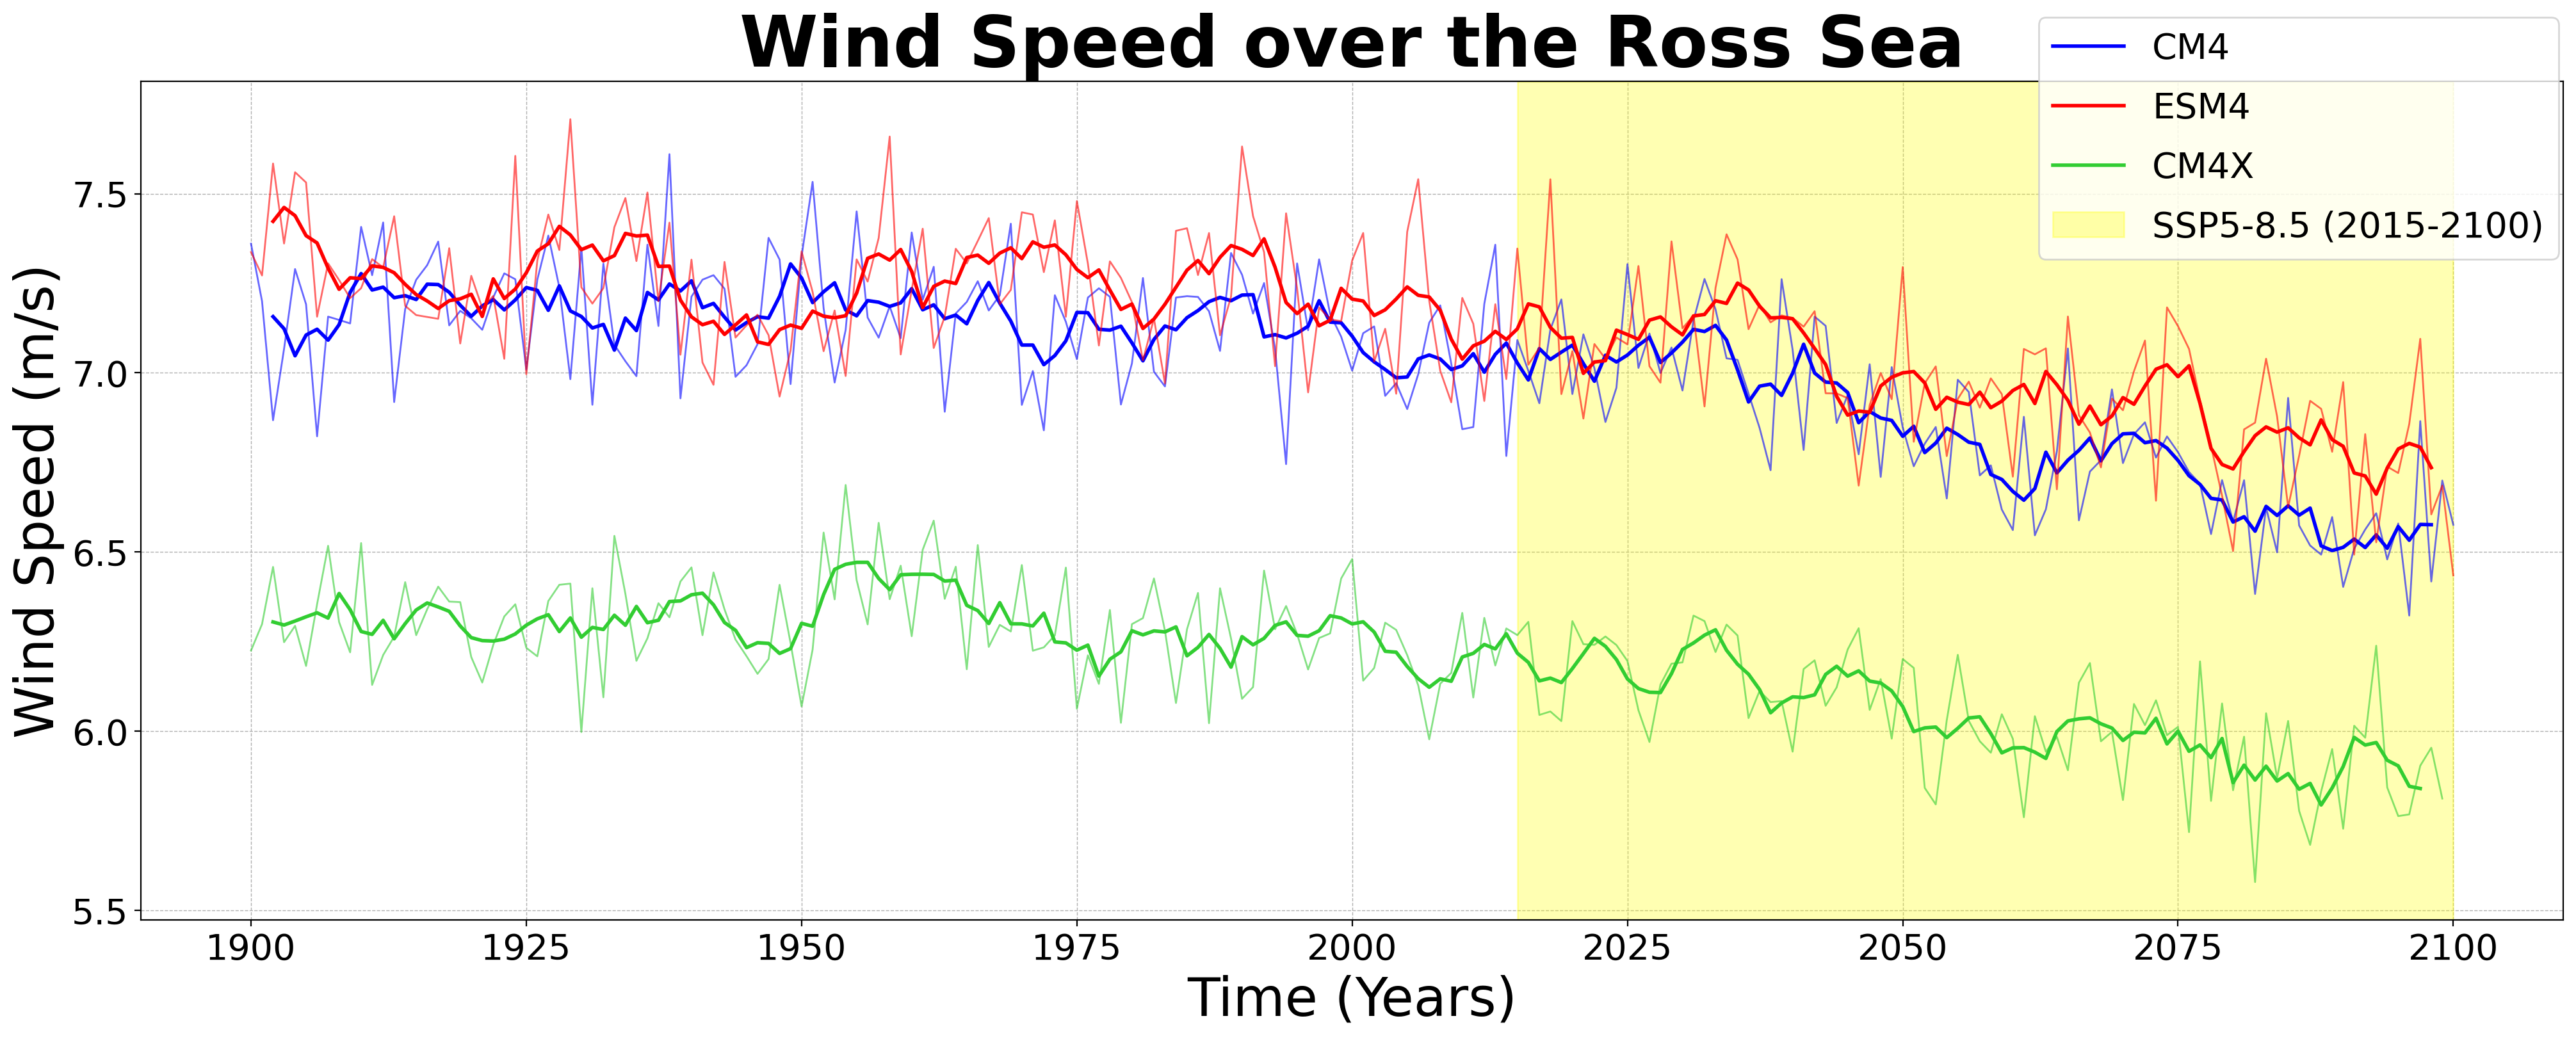

In [49]:

fig, ax= plt.subplots( layout='constrained', figsize= (20,8))

ax.plot(CM4_ross_dsw_timeseries.time.dt.year,
           CM4_ross_dsw_timeseries,
           color='blue', linewidth=1, alpha=0.6)

ax.plot(CM4_ross_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4_ross_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='blue', label='CM4', linewidth=2)


ax.plot(ESM4_ross_dsw_timeseries.time.dt.year,
           ESM4_ross_dsw_timeseries,
           color='red', linewidth=1, alpha=0.6)

ax.plot(ESM4_ross_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           ESM4_ross_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='red', label='ESM4', linewidth=2)


ax.plot(CM4X_ross_dsw_timeseries.time.dt.year,
           CM4X_ross_dsw_timeseries,
           color='limegreen', linewidth=1, alpha=0.6)

ax.plot(CM4X_ross_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4X_ross_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='limegreen', label='CM4X', linewidth=2)


#ax.plot(ERA5_ross_dsw_timeseries.time.dt.year, ERA5_ross_dsw_timeseries, color='black', linewidth=1, alpha=0.6)

#ax.plot(ERA5_ross_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year, ERA5_ross_dsw_timeseries.rolling(time=5,center=True).mean(),  color='black', label='ERA5', linewidth=2)



ax.set_title('Wind Speed over the Ross Sea', fontsize=40, fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)



ax.set_ylabel('Wind Speed (m/s)', fontsize=30)
ax.set_xlabel('Time (Years)', fontsize=30)


ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)

ax.axvspan(2015, 2100, color='yellow', alpha=0.3, label='SSP5-8.5 (2015-2100)')

fig.legend(labelspacing=0.7, fontsize=20)






#plt.savefig('rossGradient_wind.png')

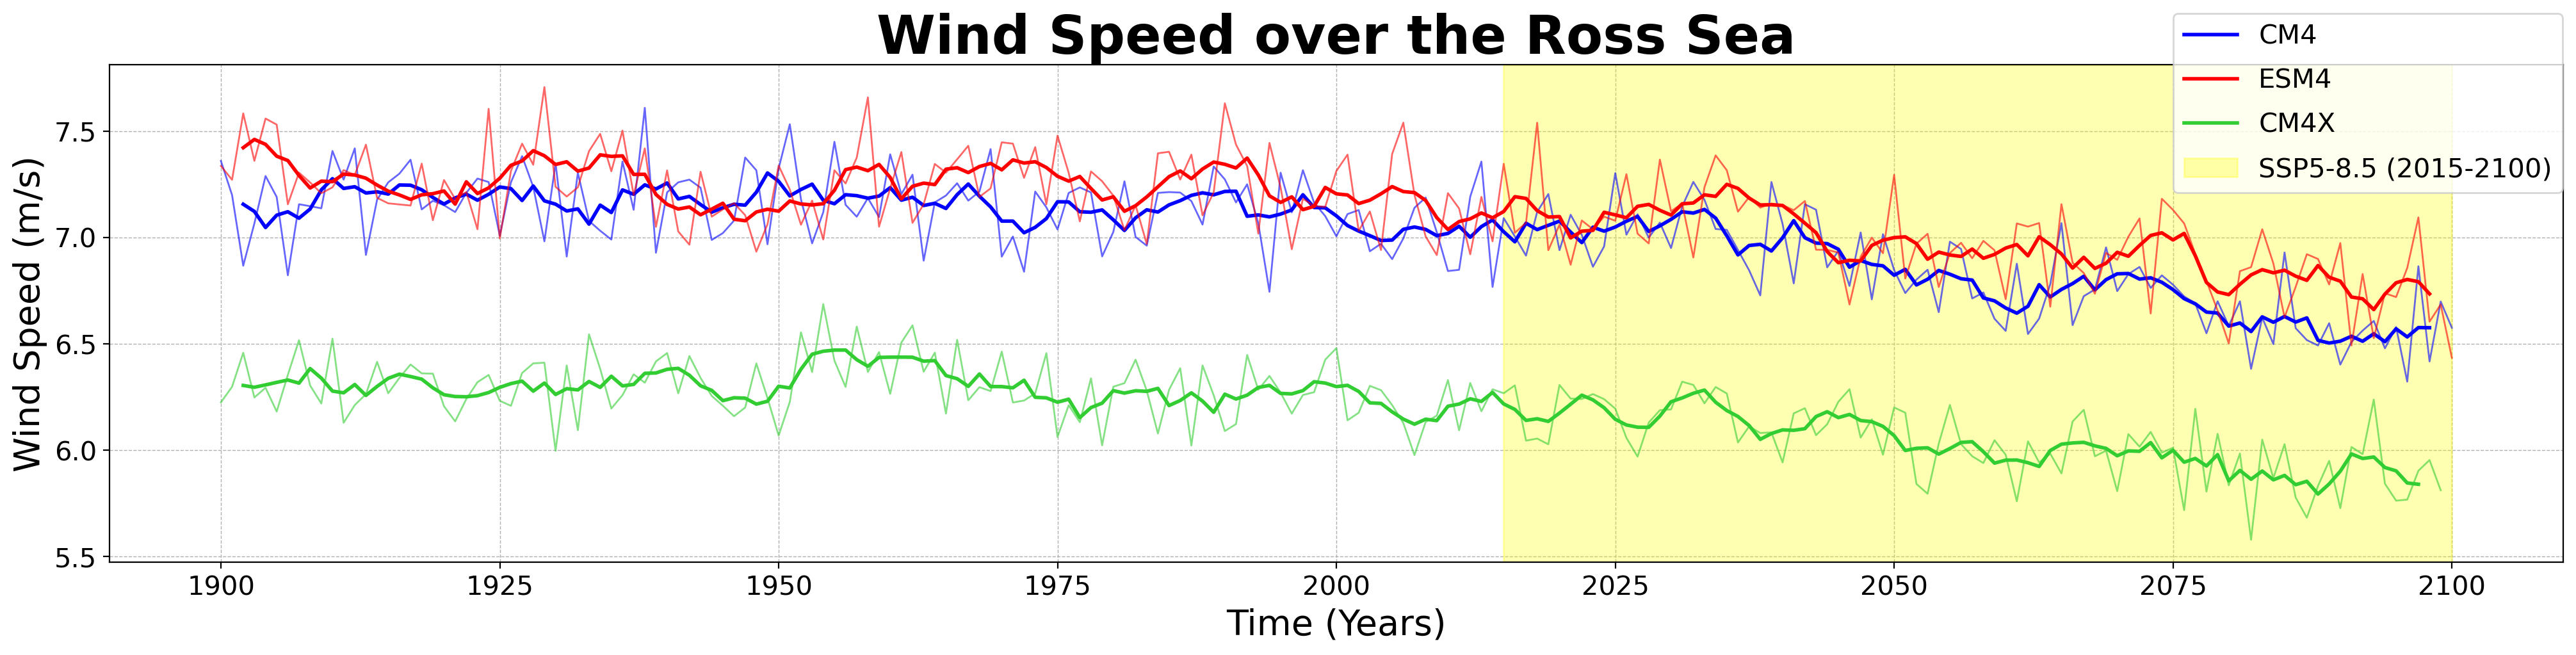

In [50]:

fig, ax= plt.subplots( layout='constrained', figsize= (20,5))

ax.plot(CM4_ross_dsw_timeseries.time.dt.year,
           CM4_ross_dsw_timeseries,
           color='blue', linewidth=1, alpha=0.6)

ax.plot(CM4_ross_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4_ross_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='blue', label='CM4', linewidth=2)


ax.plot(ESM4_ross_dsw_timeseries.time.dt.year,
           ESM4_ross_dsw_timeseries,
           color='red', linewidth=1, alpha=0.6)

ax.plot(ESM4_ross_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           ESM4_ross_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='red', label='ESM4', linewidth=2)


ax.plot(CM4X_ross_dsw_timeseries.time.dt.year,
           CM4X_ross_dsw_timeseries,
           color='limegreen', linewidth=1, alpha=0.6)

ax.plot(CM4X_ross_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4X_ross_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='limegreen', label='CM4X', linewidth=2)


#ax.plot(ERA5_ross_dsw_timeseries.time.dt.year, ERA5_ross_dsw_timeseries, color='black', linewidth=1, alpha=0.6)

#ax.plot(ERA5_ross_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year, ERA5_ross_dsw_timeseries.rolling(time=5,center=True).mean(),  color='black', label='ERA5', linewidth=2)



ax.set_title('Wind Speed over the Ross Sea', fontsize=30, fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)



ax.set_ylabel('Wind Speed (m/s)', fontsize=20)
ax.set_xlabel('Time (Years)', fontsize=20)


ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)

ax.axvspan(2015, 2100, color='yellow', alpha=0.3, label='SSP5-8.5 (2015-2100)')

fig.legend(labelspacing=0.7, fontsize=15)






#plt.savefig('rossGradient_wind.png')

In [51]:
CM4_adelie_dsw_timeseries

<xarray.DataArray (time: 201)>
dask.array<concatenate, shape=(201,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 10.0
  * time     (time) object 1900-07-02 12:00:00 ... 2100-07-02 12:00:00

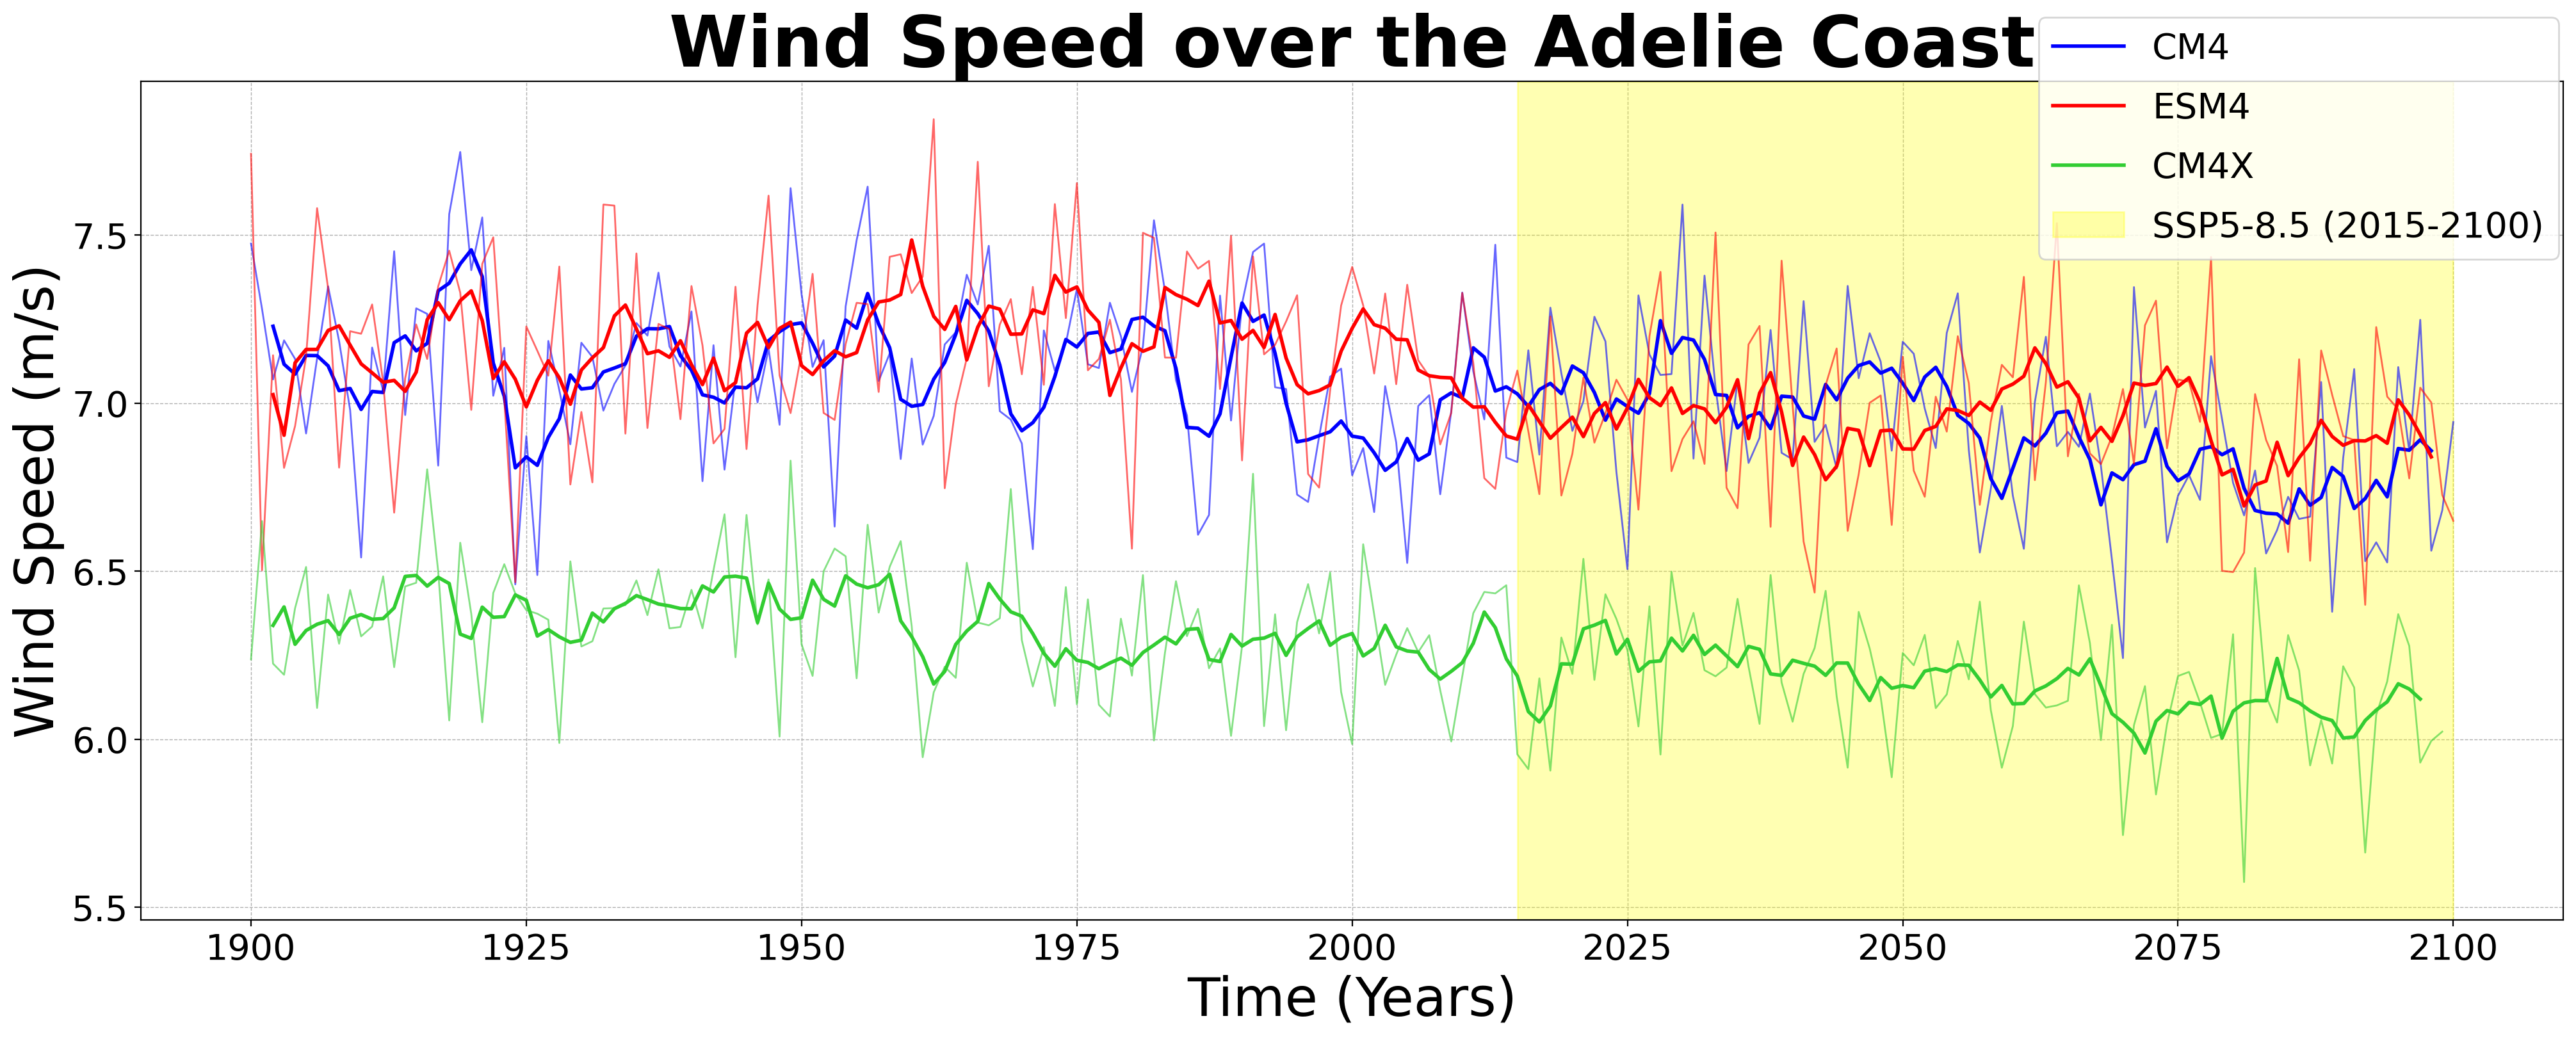

In [52]:

fig, ax= plt.subplots( layout='constrained', figsize= (20,8))

ax.plot(CM4_adelie_dsw_timeseries.time.dt.year,
           CM4_adelie_dsw_timeseries,
           color='blue', linewidth=1, alpha=0.6)

ax.plot(CM4_adelie_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4_adelie_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='blue', label='CM4', linewidth=2)


ax.plot(ESM4_adelie_dsw_timeseries.time.dt.year,
           ESM4_adelie_dsw_timeseries,
           color='red', linewidth=1, alpha=0.6)

ax.plot(ESM4_adelie_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           ESM4_adelie_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='red', label='ESM4', linewidth=2)


ax.plot(CM4X_adelie_dsw_timeseries.time.dt.year,
           CM4X_adelie_dsw_timeseries,
           color='limegreen', linewidth=1, alpha=0.6)

ax.plot(CM4X_adelie_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4X_adelie_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='limegreen', label='CM4X', linewidth=2)


#ax.plot(ERA5_adelie_dsw_timeseries.time.dt.year, ERA5_adelie_dsw_timeseries,color='black', linewidth=1, alpha=0.6)

#ax.plot(ERA5_adelie_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,ERA5_adelie_dsw_timeseries.rolling(time=5,center=True).mean(),color='black', label='ERA5', linewidth=2)



ax.set_title('Wind Speed over the Adelie Coast', fontsize=40,fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)



ax.set_ylabel('Wind Speed (m/s)', fontsize=30)
ax.set_xlabel('Time (Years)', fontsize=30)


ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)

ax.axvspan(2015, 2100, color='yellow', alpha=0.3, label='SSP5-8.5 (2015-2100)')

fig.legend(labelspacing=0.7, fontsize=20)






#plt.savefig('adelieGradient_wind.png')

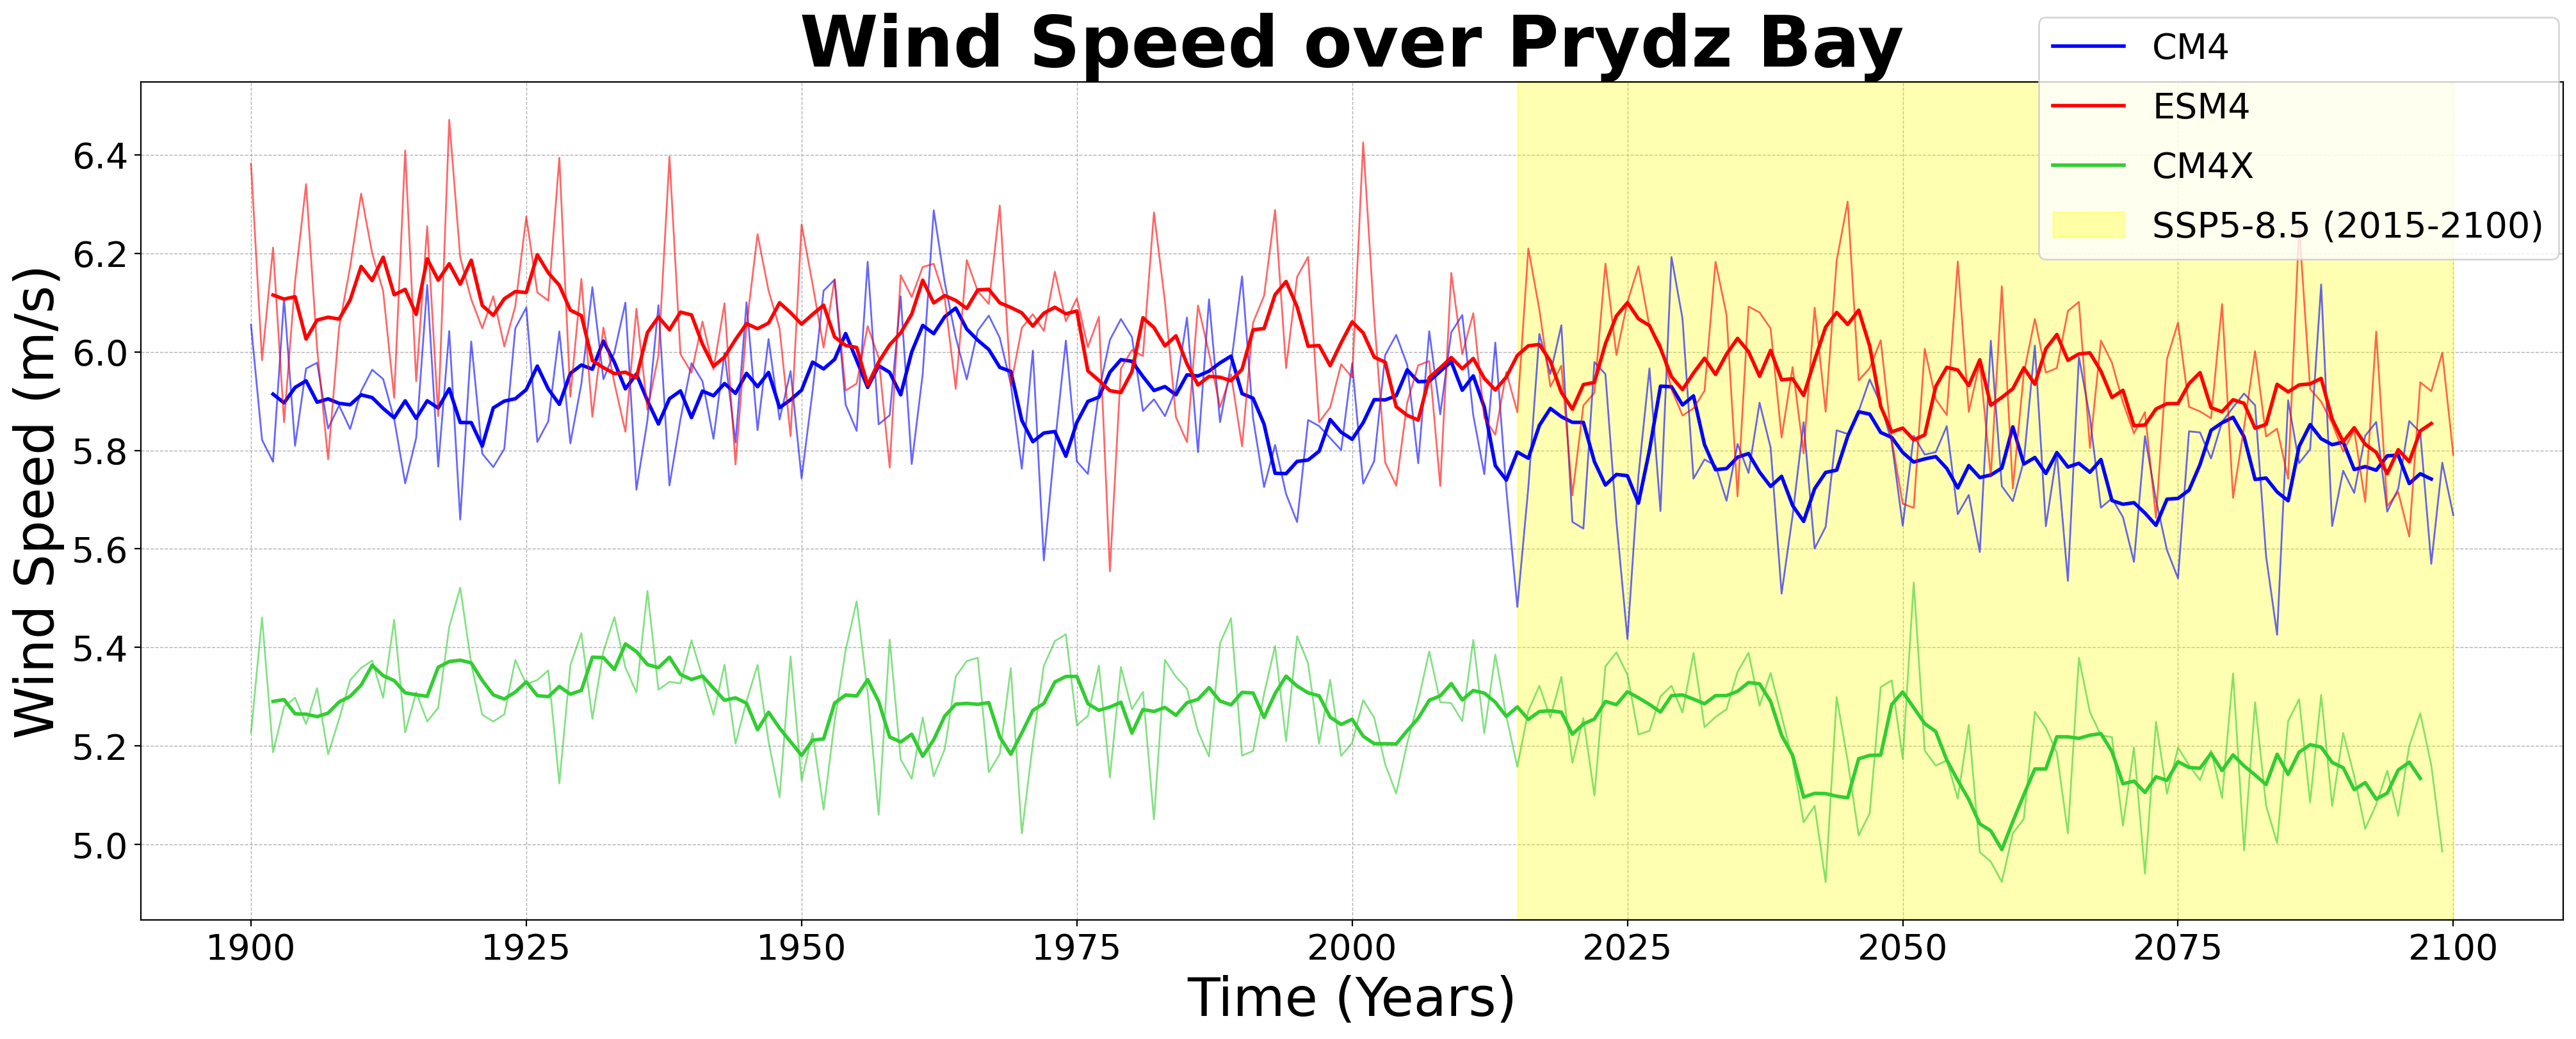

In [53]:

fig, ax= plt.subplots( layout='constrained', figsize= (20,8))

ax.plot(CM4_pbay_dsw_timeseries.time.dt.year,
           CM4_pbay_dsw_timeseries,
           color='blue', linewidth=1, alpha=0.6)

ax.plot(CM4_pbay_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4_pbay_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='blue', label='CM4', linewidth=2)


ax.plot(ESM4_pbay_dsw_timeseries.time.dt.year,
           ESM4_pbay_dsw_timeseries,
           color='red', linewidth=1, alpha=0.6)

ax.plot(ESM4_pbay_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           ESM4_pbay_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='red', label='ESM4', linewidth=2)


ax.plot(CM4X_pbay_dsw_timeseries.time.dt.year,
           CM4X_pbay_dsw_timeseries,
           color='limegreen', linewidth=1, alpha=0.6)

ax.plot(CM4X_pbay_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year,
           CM4X_pbay_dsw_timeseries.rolling(time=5,center=True).mean(),
           color='limegreen', label='CM4X', linewidth=2)


#ax.plot(ERA5_pbay_dsw_timeseries.time.dt.year,ERA5_pbay_dsw_timeseries,color='black', linewidth=1, alpha=0.6)

#ax.plot(ERA5_pbay_dsw_timeseries.rolling(time=5,center=True).mean().time.dt.year, ERA5_pbay_dsw_timeseries.rolling(time=5,center=True).mean(), color='black', label='ERA5', linewidth=2)



ax.set_title('Wind Speed over Prydz Bay', fontsize=40,fontweight='bold')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)



ax.set_ylabel('Wind Speed (m/s)', fontsize=30)
ax.set_xlabel('Time (Years)', fontsize=30)


ax.grid(linewidth=0.5, linestyle= '--')
ax.set_axisbelow(True)

ax.axvspan(2015, 2100, color='yellow', alpha=0.3, label='SSP5-8.5 (2015-2100)')

fig.legend(labelspacing=0.7, fontsize=20)






#plt.savefig('pbayGradient_wind.png')